In [27]:
import logging

import numpy as np
import xgboost as xgb
import talib
from binance.enums import HistoricalKlinesType
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from main_funcs import get_and_update_data

In [28]:
# configs
country=None
joft = "BTCUSDT"
interval = "4h"

# remove small candle 
zero_remover_pct = 0.0

# add history of open_close_pct 
open_close_pct_history_count = 80

# add history of max_low_high_pct 
max_low_high_pct_history_count = 80

# calculate rsi with different lengths 
rsi_ranges = range(14, 21)

# add history of rsi
rsi_history_count = 80

# add moving average of rsi
rsi_ma_lengths = [3,7,9,10,14,20,50,100]
rsi_ma_ranges = [14,19,20]


In [29]:
# validation config

# valid rsi_ma_ranges
for r in  rsi_ma_ranges:
    if not r in rsi_ranges:
        raise ValueError("rsi_ma_ranges items is not in rsi_ranges")

In [30]:
# get data from database
df_source = get_and_update_data(joft, interval, HistoricalKlinesType.SPOT, country=country)
df_source = df_source[["open", "high", "low", "close", "volume"]]
# df_source.tail(1)

In [31]:
# calculate parameters
df_cal = df_source.copy()

# change from open to other columns
df_cal['open_close'] = df_cal.close - df_cal.open
df_cal['open_low'] = df_cal.low - df_cal.open
df_cal['open_high'] = df_cal.high - df_cal.open

# change percent from open to other columns
df_cal['open_close_pct'] = df_cal.open_close / df_cal.open
df_cal['open_low_pct'] = df_cal.open_low / df_cal.open
df_cal['open_high_pct'] = df_cal.open_high / df_cal.open

# price direction
# df_target['open_close_direction'] = np.sign(df_target["open_close"])
# df_target['open_open_high_direction'] = np.sign(df_target["open_low"]).astype(int)
# df_target['open_high_direction'] = np.sign(df_target["open_high"]).astype(int)

# max abs low and high
df_cal['max_low_high_pct'] = np.where(
    df_cal['open_low_pct'].abs() > df_cal['open_high_pct'].abs(),
    df_cal['open_low_pct'],
    df_cal['open_high_pct']
)

# open_close_pct history
for h in range(0,open_close_pct_history_count+1):
    df_cal[f"open_close_pct__{h}"] = df_cal.open_close_pct.shift(h)
    

# max_low_high_pct history
for h in range(0,max_low_high_pct_history_count+1):
    df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
    

# calculate multi rsi
for rsi in rsi_ranges:
    for h in range(0, rsi_history_count + 1):
        df_cal[f"rsi_{rsi}__{h}"] = talib.RSI(df_cal.close.shift(h), timeperiod=rsi)
        
# calculate rsi sma 
for ma_length in rsi_ma_lengths:
    for rsi in rsi_ma_ranges:
        df_cal[f"rsi_{rsi}_ma_{ma_length}"] =  talib.SMA(df_cal[f"rsi_{rsi}__{0}"], timeperiod=ma_length)
# df_cal

C:\Users\sajja\AppData\Local\Temp\ipykernel_12380\3199498739.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
C:\Users\sajja\AppData\Local\Temp\ipykernel_12380\3199498739.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cal[f"max_low_high_pct__{h}"] = df_cal.max_low_high_pct.shift(h)
C:\Users\sajja\AppData\Local\Temp\ipykernel_12380\3199498739.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.inse

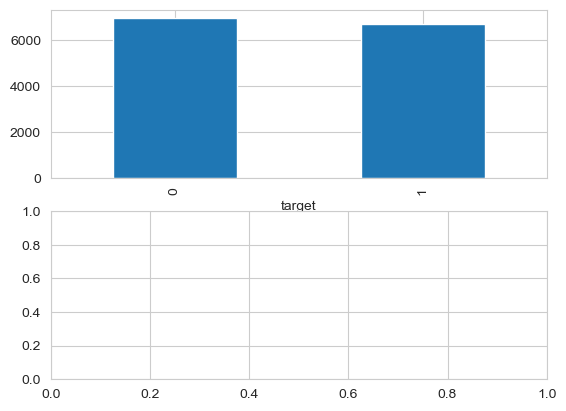

In [32]:
# create calculate target
df_target = df_cal.copy()

# calculate target
df_target["target"] = np.where(
    df_target['max_low_high_pct'] > zero_remover_pct,
    1,
    np.where(
        df_target['max_low_high_pct'] < -zero_remover_pct,
        -1, 0
    )
)

# convert -1 and 1 and 0 to True False for better result
df_target["target"] = np.where(df_target['target'] ==1, 1,0)


# show chart
fig, axs = plt.subplots(2, 1)
df_target["target"].value_counts().plot(kind='bar', ax=axs[0])
# (np.sign(df_target["open_close"]) == np.sign(df_target["target"])).value_counts().plot(kind='bar',ax=axs[1])

# shift target the real place
df_target["target"] = df_target["target"].shift(-1)
# df_target

In [33]:
# clean data
df = df_target.copy()
df.dropna(inplace=True)
df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'open_close', 'open_low', 'open_high',
                 'open_close_pct', 'open_low_pct', 'open_high_pct', 'max_low_high_pct'], inplace=True)
df

,open_close_pct__0,open_close_pct__1,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__5,open_close_pct__6,open_close_pct__7,open_close_pct__8,open_close_pct__9,...,rsi_14_ma_20,rsi_19_ma_20,rsi_20_ma_20,rsi_14_ma_50,rsi_19_ma_50,rsi_20_ma_50,rsi_14_ma_100,rsi_19_ma_100,rsi_20_ma_100,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-09-06 03:30:00,0.014549,-0.017024,0.073063,-0.022981,0.013561,0.048586,-0.028958,-0.020752,0.046983,-0.033222,...,42.037690,43.834952,44.145427,55.628189,55.339521,55.251943,53.237467,52.137396,51.946405,0.0
2017-09-06 07:30:00,0.002965,0.014549,-0.017024,0.073063,-0.022981,0.013561,0.048586,-0.028958,-0.020752,0.046983,...,42.712809,44.207172,44.477102,55.492443,55.218305,55.135556,53.363535,52.263065,52.071045,1.0
2017-09-06 11:30:00,0.016085,0.002965,0.014549,-0.017024,0.073063,-0.022981,0.013561,0.048586,-0.028958,-0.020752,...,43.131036,44.407638,44.648625,55.439010,55.161486,55.080964,53.487150,52.389199,52.196577,0.0
2017-09-06 15:30:00,0.016468,0.016085,0.002965,0.014549,-0.017024,0.073063,-0.022981,0.013561,0.048586,-0.028958,...,43.480691,44.566090,44.781775,55.541427,55.219154,55.134937,53.679808,52.566354,52.370760,0.0
2017-09-06 19:30:00,0.000000,0.016468,0.016085,0.002965,0.014549,-0.017024,0.073063,-0.022981,0.013561,0.048586,...,44.265636,45.081298,45.259055,55.573835,55.226238,55.141008,53.873328,52.744117,52.545518,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:30:00,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,-0.000483,-0.000906,...,64.846400,64.228239,64.091498,60.159749,59.787319,59.747311,58.812783,59.648081,59.798802,0.0
2023-11-12 23:30:00,-0.001101,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,-0.000483,...,63.911260,63.567453,63.469807,60.330847,59.949063,59.904931,58.807361,59.616593,59.763510,1.0
2023-11-13 03:30:00,-0.004050,-0.001101,-0.001267,0.002607,-0.001951,0.003763,-0.003803,-0.000506,0.002645,0.001683,...,63.558820,63.353727,63.274473,60.403804,60.043242,59.999026,58.744323,59.545804,59.691273,0.0


In [34]:
# analyse df
print("shape df: ", df.shape)
corr = df.corr()['target'].sort_values(ascending=False)
corr

shape df:  (13541, 754)


target                  1.000000
max_low_high_pct__3     0.026888
max_low_high_pct__15    0.026505
open_close_pct__15      0.025389
open_close_pct__3       0.023335
                          ...   
max_low_high_pct__18   -0.017926
open_close_pct__0      -0.018449
open_close_pct__18     -0.020633
open_close_pct__5      -0.054644
max_low_high_pct__5    -0.061553
Name: target, Length: 754, dtype: float64

In [35]:
# idea: remove down corr
not_important_columns = corr[corr < 0.005 ]
not_important_columns_name =  not_important_columns.index
df.drop(columns=not_important_columns_name, inplace=True)
df

,open_close_pct__2,open_close_pct__3,open_close_pct__4,open_close_pct__7,open_close_pct__8,open_close_pct__9,open_close_pct__10,open_close_pct__11,open_close_pct__15,open_close_pct__16,...,rsi_20_ma_14,rsi_14_ma_20,rsi_19_ma_20,rsi_20_ma_20,rsi_19_ma_50,rsi_20_ma_50,rsi_14_ma_100,rsi_19_ma_100,rsi_20_ma_100,target
open_time,,,,,,,,,,,,,,,,,,,,,
2017-09-06 03:30:00,0.073063,-0.022981,0.013561,-0.020752,0.046983,-0.033222,0.012421,-0.035380,-0.020352,-0.027008,...,42.484157,42.037690,43.834952,44.145427,55.339521,55.251943,53.237467,52.137396,51.946405,0.0
2017-09-06 07:30:00,-0.017024,0.073063,-0.022981,-0.028958,-0.020752,0.046983,-0.033222,0.012421,0.040905,-0.020352,...,42.734021,42.712809,44.207172,44.477102,55.218305,55.135556,53.363535,52.263065,52.071045,1.0
2017-09-06 11:30:00,0.014549,-0.017024,0.073063,0.048586,-0.028958,-0.020752,0.046983,-0.033222,-0.004398,0.040905,...,43.615005,43.131036,44.407638,44.648625,55.161486,55.080964,53.487150,52.389199,52.196577,0.0
2017-09-06 15:30:00,0.002965,0.014549,-0.017024,0.013561,0.048586,-0.028958,-0.020752,0.046983,-0.036513,-0.004398,...,44.969383,43.480691,44.566090,44.781775,55.219154,55.134937,53.679808,52.566354,52.370760,0.0
2017-09-06 19:30:00,0.016085,0.002965,0.014549,-0.022981,0.013561,0.048586,-0.028958,-0.020752,-0.035380,-0.036513,...,46.392341,44.265636,45.081298,45.259055,55.226238,55.141008,53.873328,52.744117,52.545518,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-12 19:30:00,-0.001951,0.003763,-0.003803,0.001683,-0.000483,-0.000906,-0.007015,0.002033,-0.007984,0.000877,...,63.626426,64.846400,64.228239,64.091498,59.787319,59.747311,58.812783,59.648081,59.798802,0.0
2023-11-12 23:30:00,0.002607,-0.001951,0.003763,0.002645,0.001683,-0.000483,-0.000906,-0.007015,0.017319,-0.007984,...,63.282614,63.911260,63.567453,63.469807,59.949063,59.904931,58.807361,59.616593,59.763510,1.0
2023-11-13 03:30:00,-0.001267,0.002607,-0.001951,-0.000506,0.002645,0.001683,-0.000483,-0.000906,0.000298,0.017319,...,62.653064,63.558820,63.353727,63.274473,60.043242,59.999026,58.744323,59.545804,59.691273,0.0


In [36]:
# create cross validator
# Data and targets
X, Y = df.iloc[:, :-1], df.iloc[:, -1]

In [37]:
# random x and y train and test
# x_train, x_test, y_train, y_test= train_test_split(
#     X, Y, test_size=.15, random_state=123
# )
# test faghat akharin vaziyat va na besorat random
test_point = int(len(X)*0.85)
x_train, x_test, y_train, y_test = X.iloc[:test_point,:],X.iloc[test_point:,:],Y.iloc[:test_point],Y.iloc[test_point:]
le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_train
xgb_clf = xgb.XGBClassifier(random_state=123)
xgb_clf.set_params(n_estimators=500)
xgb_clf.fit(x_train, y_train)
y_preds = xgb_clf.predict(x_test)
accuracy = float(np.sum(y_preds==y_test))/y_test.shape[0]
print("Baseline accuracy:", accuracy)
print(metrics.classification_report(y_test,y_preds))

Baseline accuracy: 0.5132874015748031
              precision    recall  f1-score   support

         0.0       0.51      0.54      0.53      1013
         1.0       0.52      0.49      0.50      1019

    accuracy                           0.51      2032
   macro avg       0.51      0.51      0.51      2032
weighted avg       0.51      0.51      0.51      2032


In [38]:
################################################
# yek noe digar baraye mohasebe
# cross validator
################################################

In [39]:
# model with cross validation
d_matrix = xgb.DMatrix(data=X, label=Y)
params = {
    'max_depth': 30 # count of tree in jungle
}
xgb_cv = xgb.cv(
    dtrain=d_matrix, 
    params=params, 
    nfold=5, # tedad ghesmatha baraye cross validation
    num_boost_round=10, # tedad max_depth agar model behtar nashod
    seed=123, # seed random baraye random haye moshabeh 
    metrics=['error'] # noe mohasebe baraye cross validation
)
xgb_cv

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.002769,0.005037,0.493982,0.009499
1,0.000258,0.000362,0.494350,0.008458
2,0.000018,0.000037,0.489920,0.007173
3,0.000000,0.000000,0.489772,0.008090
4,0.000000,0.000000,0.489477,0.006926
5,0.000000,0.000000,0.489846,0.008755
6,0.000000,0.000000,0.490141,0.006910
7,0.000000,0.000000,0.490732,0.006667
8,0.000000,0.000000,0.490142,0.007996
9,0.000000,0.000000,0.488886,0.007215
